### About
This notebook contains simple, toy examples to help you get started with FairMLHealth tool usage. This same content is mirrored in the repository's main [README](../../../README.md)

### Example Setup

In [1]:
from fairmlhealth import report as fr, analyze


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, TweedieRegressor

In [2]:

np.random.seed(506)

# Load data
X = pd.DataFrame({'col1': np.random.randint(1, 50, 32), 
                  'col2': np.random.randint(1, 50, 32),
                  'col3': np.random.randint(1, 50, 32),
                  'gender': [0, 1]*16, 
                  'ethnicity': [1, 1, 0, 0]*8,
                  'other': [1, 0, 0, 1]*8
                 })

y = pd.Series(np.random.uniform(0, 8, 32), index=X.index, name="y")
X_train, y_train= X.iloc[0:8], y.iloc[0:8]
X_test, y_test = X.iloc[8:32], y.iloc[8:32]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=36)

#Train models
model_1 = LinearRegression().fit(X_train, y_train)
model_2 = TweedieRegressor().fit(X_train, y_train)

# Deterimine your set of protected attributes
prtc_attr = X_test['gender']

# Specify either a dict or a list of trained models to compare
model_dict = {'model_1': model_1, 'model_2': model_2}


In [3]:
display(X.head())

,col1,col2,col3,gender,ethnicity,other
0,15,37,27,0,1,1
1,16,46,41,1,1,0
2,21,10,12,0,0,0
3,48,24,5,1,0,1
4,16,39,7,0,1,1


### Model Measurement
The primary feature of this library is the model comparison tool. The current version supports assessment of binary prediction models through use of the measure_models and compare_models functions.

Measure_model is designed to generate a report of multiple fairness metrics for a single model. Here it is shown wrapped in a "flag" function to emphasize values that are outside of the "fair" range. 

In [4]:
# Generate a pandas dataframe of measures
fr.measure_model(X_test, y_test, prtc_attr, model_1, pred_type="regression")


~/repos/fairMLHealth/fairmlhealth/report.py:320: UserWarning: Please note that probabilities could not be generated for the following models: ['model 1']. Dependent metrics will be skipped.
  warnings.warn("Please note that probabilities could not be " +


### Evaluating

FairMLHealth now also includes stratified table features to aid in identifying the source of unfairness or other bias: data tables, performance tables, and bias tables. Note that these stratified tables can evaluate multiple features at once, and that there are two options for identifying which features to assess.

Note that the flag tool has not yet been updated to work with stratified tables.

#### Stratified Data Tables

The data table is shown below with each of the two data argument options. It evaluates basic statistics specific to each feature-value, in addition to relative statistics for the target value. Since the table can be used to evaluate many features at once, it can be a useful option for identifying patterns of bias either alone or in concert with other (e.g., visual methods).

In [5]:
# Arguments Option 1: pass full set of data, subsetting with *features* argument
analyze.data(X_test, y_test, features=['gender'])

,Feature Name,Feature Value,Obs.,Entropy,Missing Values,Value Prevalence,y Mean,y Median,y Std. Dev.
0,ALL FEATURES,ALL VALUES,24,NaN,0,1.0,3.8811,3.4968,2.2052
1,gender,0,12,1.0,0,0.5,3.6278,3.1656,1.6499
2,gender,1,12,1.0,0,0.5,4.1344,3.9772,2.7029


#### Stratified Performance Tables

The stratified performance table can be used to evaluate model performance specific to each feature-value subset. If prediction probabilities are available to the model, additional ROC AUC and PR AUC values will be included.

In [6]:
analyze.performance(X_test[['gender']], y_test, 
                           model_1.predict(X_test), pred_type="regression")

,Feature Name,Feature Value,Obs.,Target Mean,Pred. Mean,Error Mean,Error Std. Dev.,MAE,MSE,Pred. Std. Dev.,Rsqrd,Target Std. Dev.
0,ALL FEATURES,ALL VALUES,24.0,3.8811,2.3952,-1.4860,4.4331,3.6405,21.0418,3.8681,NaN,2.2052
1,gender,0,12.0,3.6278,4.6522,1.0244,2.9045,2.5597,8.7827,2.5198,NaN,1.6499
2,gender,1,12.0,4.1344,0.1381,-3.9963,4.3481,4.7213,33.3008,3.7174,NaN,2.7029


#### Stratified Bias Fairness Tables

The stratified bias table presents model bias specific to each feature-value subset. Inspired by common measures of fairness, the table generator assumes each feature-value as the "privileged" group relative to all other possible values for the feature. For example, row 3 in the table below displaying measures of "col1" value of "2" where 2 is considered to be the privileged group and all other values (1, 2, 45, and 50) are considered unprivileged.

To simplify the table, fairness measures have been reduced to their component parts. For example, measures of Equalized Odds can be determined by combining the True Positive Rate (TPR) Ratios & Differences with False Positive Rate (FPR) Ratios & Differences.

See also: [Fairness Quick References](../docs/Fairness_Quick_References.pdf) and the [Tutorial for Evaluating Fairness in Binary Classification](./Tutorial-EvaluatingFairnessInBinaryClassification.ipynb)

In [7]:
analyze.bias(X_test[['gender', 'col2']], y_test, 
                    model_1.predict(X_test), pred_type="regression")

,Feature Name,Feature Value,MAE Difference,MAE Ratio,Mean Prediction Difference,Mean Prediction Ratio
0,gender,0,2.1616,1.8445,-4.5141,0.0297
1,gender,1,-2.1616,0.5422,4.5141,33.6853
2,col2,1,-3.3681,0.4660,3.4065,-10.2934
3,col2,16,-0.7400,0.8299,-2.2785,0.5024
4,col2,18,1.3629,1.5839,-2.4309,0.4855
5,col2,24,-0.3934,0.9021,1.3923,2.3125
6,col2,25,-1.0667,0.7712,1.0284,1.7296
7,col2,26,0.5574,1.1795,-3.3107,0.4054
8,col2,29,3.1935,5.4786,-1.6774,0.5735
9,col2,30,0.8126,1.2840,-5.6895,0.2750


## Special Cases

### Hypothetical Example for which Only Mid-Range Values Need Be Accurate

Patients undergoing a multi-stage surgical procedure, the treatment times for which are predicted by a machine learning model.

| Average Predicted Time in Surgery | Intervention |
| - | - |
|0-5 hours | Outpatient Procedures |
|5-9 hours | Treatment Decision Depends on Predicted Trends in Surgery Time |
| 9+ hours | Inpatient Procedures |

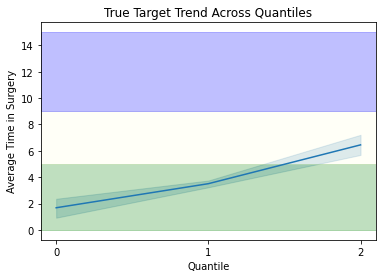

In [8]:
# Generate quantiles
quantiles = pd.qcut(y_test, 3, labels=False).rename('quantile')

# Generate plots
g = sns.lineplot(x=quantiles, y=y_test)
g.axhspan(0, 5, alpha=0.25, color='green')
g.axhspan(5, 9, alpha=0.25, color='lightyellow')
g.axhspan(9, 15, alpha=0.25, color='blue')
plt.xticks([*range(3)], [*range(3)])
g.set_xlabel("Quantile")
g.set_ylabel("Average Time in Surgery")
g.set_title("True Target Trend Across Quantiles")
plt.show()


## Cohort Analysis

In [9]:
analyze.bias(X_test[['gender', 'col2']], y_test, model_1.predict(X_test), 
                    pred_type="regression", cohorts=quantiles)

,quantile,Feature Name,Feature Value,MAE Difference,MAE Ratio,Mean Prediction Difference,Mean Prediction Ratio
0,0,gender,0,1.9891,1.6975,-4.7541,-0.4573
1,0,gender,1,-1.9891,0.5891,4.7541,-2.1869
2,0,col2,1,-2.7982,0.5293,5.4551,-0.7015
3,0,col2,16,-0.5751,0.8678,-4.2211,0.0781
4,0,col2,26,0.8459,1.2723,-5.3516,0.0389
5,0,col2,34,2.5357,2.5578,2.6904,-0.8317
6,0,col2,37,4.1103,17.4470,-1.4571,0.3255
7,0,col2,40,-1.0267,0.7836,-5.4141,0.0371
8,0,col2,44,-1.0932,0.7724,4.4019,-0.4839
9,1,gender,0,0.4147,1.1832,-4.4041,0.1902
